## PSG COLLEGE OF TECHNOLOGY
## ML LAB CA 2
### 19PD05 ~ ALAGU PRAKALYA

### TEXT CLASSIFICATION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix,accuracy_score,mean_squared_error,classification_report,precision_score,roc_auc_score,roc_curve,auc
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.calibration import CalibratedClassifierCV

from wordcloud import WordCloud

In [2]:
import string                              # for string operations
import nltk  
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle

## DATA : mammo_report

In [99]:
df=pd.read_csv("mammoreport.csv")
df2=df

In [4]:
df.head()

,Features,Birads
0,Soft tissue mass lesion (23 x 20 mm) with spic...,4
1,Parenchyma is predominantly FATTY.No distinctl...,1
2,Parenchyma is predominantly GLANDULAR. No dist...,1
3,Parenchyma is predominantly GLANDULAR. No dist...,2
4,Parenchyma is GLANDULAR and FATTY. Small subce...,2


In [5]:
df.shape

(107, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Features  107 non-null    object
 1   Birads    107 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [7]:
df.describe()

,Birads
count,107.000000
mean,2.233645
std,1.356879
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


## No. of classes for classification

In [8]:
df['Birads'].unique()

array([4, 1, 2, 3, 5, 0, 6], dtype=int64)

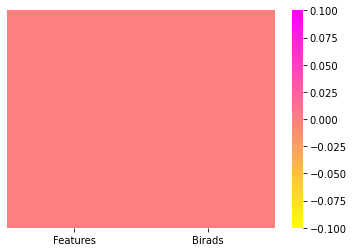

In [9]:
sns.heatmap(df.isnull(),yticklabels=False,cmap='spring_r') # since the output is completely pink there exist no null values in tha data set

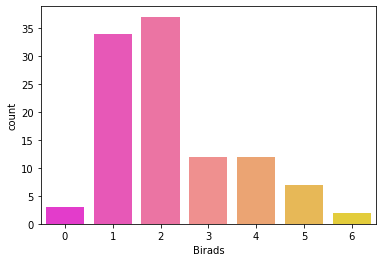

In [10]:
sns.countplot(x='Birads',data=df,palette='spring') #Distribution of each classes

## Data pre-processing :

In [11]:
def listToString(s): 
    str1 =""  
    for ele in s: 
        str1 += ele  
        str1+=" "
    return str1 

In [12]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def pre_processing(text):
    #convert the text into lower
    text=text.lower()
    #remove punctuations and extra spaces
    text= re.sub(r'\d+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text=text.translate(translator)
    text=" ".join(text.split())
    #tokenize the pre-processed text
    word_tokens = nltk.word_tokenize(text)
    text = [word for word in word_tokens if word.isalnum()]
    #since we obtain output as list, convert it to string and perform stemming and lemmatizing
    text=listToString(text)
    word_tokens = word_tokenize(text)
    text = [stemmer.stem(word) for word in word_tokens]
    text=listToString(text)
    word_tokens = word_tokenize(text)
    text = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    text=listToString(text)
    return text

In [118]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df2['Features']).toarray()
final_features.shape

(107, 366)

### In the copied dataframe we apply the pre-processing techniques used in NLP toolkit : 107 ,since no.of rows

In [100]:
for i in range(0,107):
    st=df2['Features'][i]
    df2['Features'][i]=pre_processing(st)

## EDA : Wordcloud

In [14]:
text = " ".join(word for word in df.Features)
word_cloud = WordCloud(collocations = False, background_color = 'white',width = 2048, height = 1080).generate(text)
word_cloud.to_file('word_cloud.png')

In [15]:
text = " ".join(word for word in df2.Features)
word_cloud2 = WordCloud(collocations = False, background_color = 'white',width = 2048, height = 1080).generate(text)
word_cloud2.to_file('word_cloud2.png')

## The left image is the word cloud generated before pre-processing and the right one is obtained after pre-processing

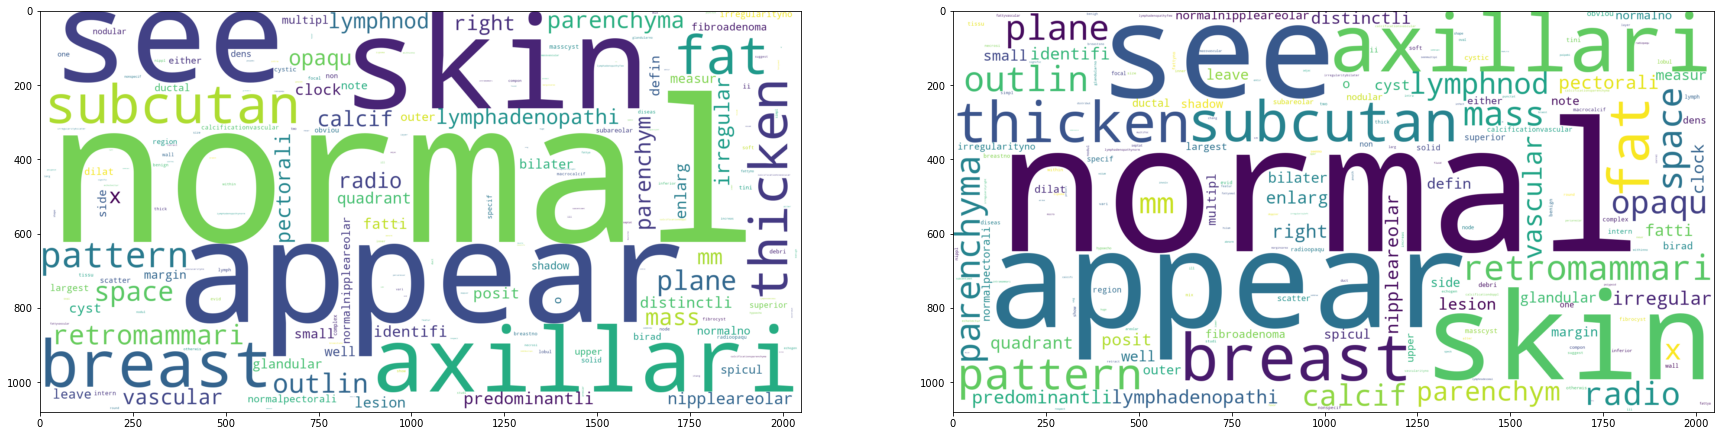

In [16]:
fig = plt.figure(figsize=(30, 30))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(word_cloud, interpolation='bilinear')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(word_cloud2, interpolation='bilinear')

### Inference : most of the freq(words) appearing mostly before and after pre-processing is similar, except on small int val change

## TEXT ANALYSIS :
### We'll use df2 for binary classification as mentioned below 
#### [0,1,2,3] belongs to class 0 and [4,5,6,7] belongs to class 1

In [94]:
df2['Birads'].replace(0,10)
df2['Birads'].replace([10,1,2,3],0,True)
df2['Birads'].replace([4,5,6,7],1,True)


In [106]:
df2 = df2[['Birads', 'Features']]

In [107]:
df2

,Birads,Features
0,1,soft tissu mass lesion x mm with spicul margin...
1,0,parenchyma be predominantli fattyno distinctli...
2,0,parenchyma be predominantli glandular no disti...
3,0,parenchyma be predominantli glandular no disti...
4,0,parenchyma be glandular and fatti small subcen...
...,...,...
102,0,parenchyma be predominantli fatti few tini ben...
103,0,parenchyma be predominantli fatti few tini ben...
104,0,parenchyma be predominantli glandular fibroade...
105,1,parenchyma be predominantli glandular a well d...


### Writing the preprocessed data into a text file for further analysis

In [115]:
df2.to_csv('feat.txt', sep='\t', index=False)

### Splitting the data : Here we had used loo~ leave one out method to test the data

In [116]:
loo = LeaveOneOut()
X=df2['Features']
y=df2['Birads']

## LOGISTIC REGRESSION

In [117]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k='all')),
                     ('clf', LogisticRegression(random_state=0))])

    model = pipeline.fit(X_train, y_train)
    with open('LogisticRegression.pickle', 'wb') as f:
        pickle.dump(model, f)

    ytest = np.array(y_test)

    # confusion matrix and classification report(precision, recall, F1-score)
    print(classification_report(ytest, model.predict(X_test)))
    print(confusion_matrix(ytest, model.predict(X_test)))

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

[[0 0]
 [1 0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

[[0 0]
 [1 0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

[[0 0]
 [1 0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall 

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

[[0 0]
 [1 0]]
              precision    recall  f1-score   support

           0       1.00      1.00      

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

[[0 0]
 [1 0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall 


[[0 0]
 [1 0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00     

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

[[1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

[[0 0]
 [1 0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  

### Without LOO (for thw whole dataset)

In [119]:
from sklearn.linear_model import LogisticRegression
X = df2['Features']
Y = df2['Birads']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k='all')),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        23
           1       0.00      0.00      0.00         4

    accuracy                           0.85        27
   macro avg       0.43      0.50      0.46        27
weighted avg       0.73      0.85      0.78        27

[[23  0]
 [ 4  0]]


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## PERCEPTRON

In [133]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def predict(x):
    if x <= 0.5:
        return 0
    else:
        return 1

def clean_text(data, remove_list):
    cleaned_text = []
    for data_unit in data:
        for char in remove_list:
            data_unit = data_unit.replace(char, '')
        data_unit = data_unit.lower()
        cleaned_text.append(data_unit)
    return cleaned_text

def shuffle_data(data_list, shuffle_factor):
    m = len(data_list)
    for i in range(shuffle_factor):
        rndIndex = randint(0, m - 1)
        tmp = data_list[rndIndex]
        rndIndex2 = randint(0, len(data_list) - 1)
        data_list[rndIndex] = data_list[rndIndex2]
        data_list[rndIndex2] = tmp
    return data_list

# Get data and features (word bag)
def get_data(data_list, start, end, word_bag):
    phrases=[]
    get_w_b = False
    if word_bag == None:
        word_bag = []
        get_w_b = True
    i=0;
    m = end - start
    Y = np.zeros(shape=(m, 1))
    for data_unit in data_list[start:end - 1]:
        splitted_data_unit = data_unit.split('\t')
        # Get Y
        Y[i, 0] = int(splitted_data_unit[0])
        words = splitted_data_unit[1].split(' ')
        if get_w_b == True:
            for word in words:
                if word not in word_bag:
                    word_bag.append(word)
        i+=1
    # Get X
    X = np.zeros(shape=(len(Y), len(word_bag)))
    i = 0;
    for data_unit in data_list[start:end - 1]:
        phrases.append(data_unit)
        splitted_data_unit = data_unit.split('\t')[1].split(' ')
        x = [0] * len(word_bag)
        word_count = {}
        for word in splitted_data_unit:
            if get_w_b == False:
                if word in word_bag:
                    if word not in word_count:
                        word_count[word] = 1.
                    else:
                        word_count[word] += 1.
            else:
                if word not in word_count:
                    word_count[word] = 1.
                else:
                    word_count[word] += 1.
        for word in word_count:
            if word in word_bag:
                x[word_bag.index(word)] = word_count[word]
        X[i]=(x)
        i += 1
    if get_w_b == True:
        return word_bag, X, Y,phrases
    else:
        return X, Y,phrases

def train_model(m, ITERATIONS, LEARNING_RATE, Y, X):
    X = X.T
    Y = Y.T
    # weights vector initialization
    w = np.zeros((X.shape[0], 1))

    # Weights random initialization
    for j in range(X.shape[0]):
        w[j, 0] = randint(-10, 10) * 0.01
    # Bias initialization
    b = 0
    # Cost initialization
    cost = 0
    for i in range(ITERATIONS):
        A = sigmoid(np.dot(w.T, X) + b)
        cost = (-1. / m) * np.sum((Y * np.log(A)) + (1. - Y) * np.log(1. - A))
        print ("EPOCH: "+str(i)+", ERROR: "+str(cost))
        if math.isnan(cost):
            return w, b
        dw = (1. / m) * np.dot(X, (A - Y).T)
        db = (1. / m) * np.sum(A - Y)
        w = w - dw * LEARNING_RATE
        b = b - db * LEARNING_RATE
    return w,b

def get_precision_stats(predicted, actual):
    TP, FP, TN, FN = 0, 0, 0, 0
    # Result precision tatistics
    for i in range(len(actual)):
        if predict(predicted[i]) == 1:
            # True positive: predicted is 1 and real is 1
            if actual[i] == 1:
                TP += 1.
            # False positive: predicted is 1 and real is 0
            elif actual[i] == 0:
                FP += 1.
        elif predict(predicted[i]) == 0:
            # True negative: predicted is 0 and real is 0
            if actual[i] == 0:
                TN += 1.
            # False negative: predicted is 0 and real is 1
            elif actual[i] == 1:
                FN += 1.
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / ( TP + FN )
    precision = TP / ( TP + FP )
    f1 = (2 * recall * precision) / (recall + precision)
    return TP, FP, TN, FN, accuracy, recall, precision, f1

In [134]:
ITERATIONS = 1000
LEARNING_RATE = 0.008
DATA_SPLIT_COEF = 0.3

ready_data =open("feat.txt", "r").readlines()

word_bag, X, Y,trainig_phrases = get_data(ready_data, 0,int(len(ready_data)*DATA_SPLIT_COEF), None)
m = X.shape[1]
w, b = train_model(m, ITERATIONS, LEARNING_RATE, Y, X)

testing_X, testing_Y,phrases = get_data(ready_data, int(len(ready_data)*DATA_SPLIT_COEF)+1, len(ready_data)-1, word_bag)
A = sigmoid(np.dot(testing_X, w) + b)

TP, FP, TN, FN, accuracy, recall, precision, f1 = get_precision_stats(A, testing_Y)


print ("------------------------------------------------------------------------------------------")
print ("PERCEPTRON")
print ("True positives: " + str(TP))
print ("True negatives: " + str(TN))
print ("False positives: " + str(FP))
print ("False negatives: " + str(FN))
print ("Accuracy: " + str(accuracy))
print ("Recall: " + str(recall))
print ("Precision: " + str(precision))
print ("F1 Score: " + str(f1))

EPOCH: 0, ERROR: 0.18133441434518635
EPOCH: 1, ERROR: 0.17633762659389407
EPOCH: 2, ERROR: 0.17158108970165473
EPOCH: 3, ERROR: 0.1670585143881401
EPOCH: 4, ERROR: 0.16276299623150672
EPOCH: 5, ERROR: 0.1586871189019698
EPOCH: 6, ERROR: 0.1548230569876213
EPOCH: 7, ERROR: 0.15116267593622357
EPOCH: 8, ERROR: 0.14769762704613842
EPOCH: 9, ERROR: 0.1444194358818504
EPOCH: 10, ERROR: 0.1413195829339347
EPOCH: 11, ERROR: 0.13838957576477676
EPOCH: 12, ERROR: 0.13562101226145643
EPOCH: 13, ERROR: 0.1330056349441698
EPOCH: 14, ERROR: 0.13053537654658298
EPOCH: 15, ERROR: 0.12820239729277577
EPOCH: 16, ERROR: 0.12599911444692702
EPOCH: 17, ERROR: 0.1239182248121826
EPOCH: 18, ERROR: 0.12195272091134185
EPOCH: 19, ERROR: 0.12009590160182919
EPOCH: 20, ERROR: 0.1183413778685731
EPOCH: 21, ERROR: 0.11668307450807193
EPOCH: 22, ERROR: 0.11511522837144528
EPOCH: 23, ERROR: 0.11363238377906192
EPOCH: 24, ERROR: 0.11222938565882032
EPOCH: 25, ERROR: 0.11090137089780959
EPOCH: 26, ERROR: 0.1096437583

EPOCH: 253, ERROR: 0.06877910774726154
EPOCH: 254, ERROR: 0.0687130622003977
EPOCH: 255, ERROR: 0.06864717951147946
EPOCH: 256, ERROR: 0.06858145896129085
EPOCH: 257, ERROR: 0.06851589983592991
EPOCH: 258, ERROR: 0.06845050142669362
EPOCH: 259, ERROR: 0.06838526302996721
EPOCH: 260, ERROR: 0.06832018394711814
EPOCH: 261, ERROR: 0.0682552634843941
EPOCH: 262, ERROR: 0.06819050095282528
EPOCH: 263, ERROR: 0.06812589566813028
EPOCH: 264, ERROR: 0.06806144695062605
EPOCH: 265, ERROR: 0.06799715412514111
EPOCH: 266, ERROR: 0.06793301652093234
EPOCH: 267, ERROR: 0.067869033471605
EPOCH: 268, ERROR: 0.06780520431503594
EPOCH: 269, ERROR: 0.06774152839329968
EPOCH: 270, ERROR: 0.06767800505259756
EPOCH: 271, ERROR: 0.06761463364318943
EPOCH: 272, ERROR: 0.06755141351932809
EPOCH: 273, ERROR: 0.06748834403919633
EPOCH: 274, ERROR: 0.0674254245648462
EPOCH: 275, ERROR: 0.06736265446214065
EPOCH: 276, ERROR: 0.06730003310069756
EPOCH: 277, ERROR: 0.06723755985383563
EPOCH: 278, ERROR: 0.067175234

EPOCH: 525, ERROR: 0.05511927034390217
EPOCH: 526, ERROR: 0.05508045352015968
EPOCH: 527, ERROR: 0.05504169665002899
EPOCH: 528, ERROR: 0.05500299955591245
EPOCH: 529, ERROR: 0.05496436206104699
EPOCH: 530, ERROR: 0.05492578398949927
EPOCH: 531, ERROR: 0.054887265166161006
EPOCH: 532, ERROR: 0.054848805416744174
EPOCH: 533, ERROR: 0.054810404567776354
EPOCH: 534, ERROR: 0.05477206244659599
EPOCH: 535, ERROR: 0.05473377888134779
EPOCH: 536, ERROR: 0.05469555370097807
EPOCH: 537, ERROR: 0.05465738673523017
EPOCH: 538, ERROR: 0.054619277814639905
EPOCH: 539, ERROR: 0.054581226770530955
EPOCH: 540, ERROR: 0.054543233435010365
EPOCH: 541, ERROR: 0.0545052976409641
EPOCH: 542, ERROR: 0.054467419222052546
EPOCH: 543, ERROR: 0.054429598012706
EPOCH: 544, ERROR: 0.05439183384812037
EPOCH: 545, ERROR: 0.0543541265642527
EPOCH: 546, ERROR: 0.054316475997816846
EPOCH: 547, ERROR: 0.05427888198627911
EPOCH: 548, ERROR: 0.054241344367853876
EPOCH: 549, ERROR: 0.054203862981499484
EPOCH: 550, ERROR: 

EPOCH: 781, ERROR: 0.04676050048341199
EPOCH: 782, ERROR: 0.0467329031073945
EPOCH: 783, ERROR: 0.04670533801613901
EPOCH: 784, ERROR: 0.04667780514577773
EPOCH: 785, ERROR: 0.04665030443265221
EPOCH: 786, ERROR: 0.04662283581331223
EPOCH: 787, ERROR: 0.046595399224514854
EPOCH: 788, ERROR: 0.04656799460322348
EPOCH: 789, ERROR: 0.04654062188660677
EPOCH: 790, ERROR: 0.046513281012037784
EPOCH: 791, ERROR: 0.04648597191709289
EPOCH: 792, ERROR: 0.04645869453955088
EPOCH: 793, ERROR: 0.046431448817391995
EPOCH: 794, ERROR: 0.046404234688796925
EPOCH: 795, ERROR: 0.04637705209214596
EPOCH: 796, ERROR: 0.04634990096601791
EPOCH: 797, ERROR: 0.0463227812491893
EPOCH: 798, ERROR: 0.046295692880633364
EPOCH: 799, ERROR: 0.04626863579951915
EPOCH: 800, ERROR: 0.04624160994521055
EPOCH: 801, ERROR: 0.046214615257265446
EPOCH: 802, ERROR: 0.04618765167543478
EPOCH: 803, ERROR: 0.04616071913966165
EPOCH: 804, ERROR: 0.046133817590080395
EPOCH: 805, ERROR: 0.046106946967015706
EPOCH: 806, ERROR: 

## NAIVE BAYES

In [158]:
df2['Features'] = df2['Features'].str.split()
vocabulary = []
for text in df2['Features']:
    for word in text:
        vocabulary.append(word)
vocabulary = list(set(vocabulary))

In [159]:
len(vocabulary)

308

In [160]:
word_count = {unique_word : [0] * len(df2['Features']) for unique_word in vocabulary}
for i, text in enumerate(df2['Features']):
    for word in text:
        word_count[word][i] += 1

In [161]:
word_count = pd.DataFrame(word_count)
word_count.head()

,fattyvascular,marginsmultipl,seensmal,and,obviou,a,marginsleft,micro,superior,parenchymaa,...,respect,ductal,subareolar,either,fattyno,calcificationvascular,seenno,over,seenmultipl,breastsno
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


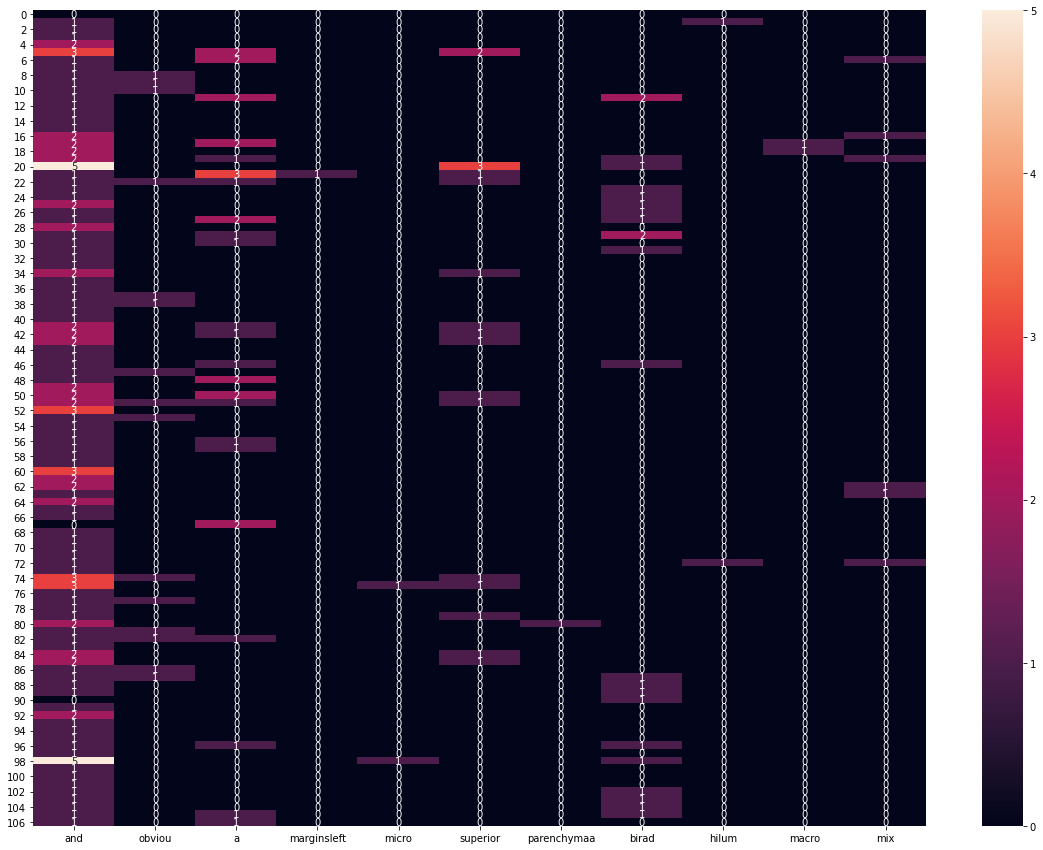

In [236]:
plt.subplots(figsize=(20,15))

sns.heatmap(word_count.iloc[:, 3:14] , annot=True)

In [162]:
df2 = pd.concat([df2, word_count], axis = 1)

In [163]:
class_0 = df2[df2['Birads'] == 0]
class_1 = df2[df2['Birads'] == 1]

#PRIOR PROBABILITIES P[SPAM], P[HAM]
P_0 = len(class_0) / len(df2)
P_1 = len(class_1) / len(df2)

print('PRIOR PROBABILITIES')
print('P[0] = {}\nP[1] = {}'.format(P_0, P_1))

PRIOR PROBABILITIES
P[0] = 0.8037383177570093
P[1] = 0.19626168224299065


In [164]:
n_words_per_0_message = class_0['Features'].apply(len)
n_0 = n_words_per_0_message.sum()
n_words_per_1_message = class_1['Features'].apply(len)
n_1= n_words_per_1_message.sum()
n_vocabulary = len(vocabulary)

In [165]:
sm_par = 1
parameters_0 = {unique_word:0 for unique_word in vocabulary}
parameters_1 = {unique_word:0 for unique_word in vocabulary}

for word in vocabulary:
    n_word_given_0 = class_0[word].sum()
    p_word_given_0 = (n_word_given_0 + sm_par) / (n_0 + sm_par * n_vocabulary)
    parameters_0[word] = p_word_given_0
    n_word_given_1 = class_1[word].sum()
    p_word_given_1 = (n_word_given_1 + sm_par) / (n_1 + sm_par * n_vocabulary)
    parameters_1[word] = p_word_given_1

In [168]:
def predict(text):
    P_0_given_text = P_0
    P_1_given_text = P_1
    for word in text:
        if word in parameters_0:
            P_0_given_text *= parameters_0[word]
        if word in parameters_1:
              P_1_given_text *= parameters_1[word]

    if P_0_given_text > P_1_given_text:
        return 0
    else:
        return 1

In [169]:
df2['predicted'] = df2['Features'].apply(predict)

In [171]:
TP = 0
FP = 0
TN = 0
FN = 0
for row in df2.iterrows():
    row = row[1]
    if row['Birads'] == 0 and row['predicted'] == 0:
        TP += 1
    elif row['Birads'] == 1 and row['predicted'] == 1:
        TN += 1
    elif row['Birads'] == 0 and row['predicted'] == 1:
        FP += 1
    else:
        FN += 1


Accuracy = (TP+TN) / (TP+TN+FP+FN)
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)
F_measure = (2 * Precision * Recall) / (Precision + Recall)

In [172]:
print('---------------------------')
print('Accuracy Measures Report  ')
print('---------------------------')
print('\nTotal no. of correct predictions : ', TP+TN)
print('Total no. of incorrect predictions : ', FP+FN)
print('\nAccuracy : ', Accuracy)
print('Precision : ', Precision)
print('Recall : ', Recall)
print('F_measure : ', F_measure)

---------------------------
Accuracy Measures Report  
---------------------------

Total no. of correct predictions :  100
Total no. of incorrect predictions :  7

Accuracy :  0.9345794392523364
Precision :  0.9534883720930233
Recall :  0.9647058823529412
F_measure :  0.9590643274853802


In [254]:
#using in-bult NB to construct the roc curve
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df2['Features'].astype(str))
X=X.toarray()
X_train, X_test, y_train, y_test = train_test_split(X, df2['Birads'], test_size=0.3, random_state=33)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

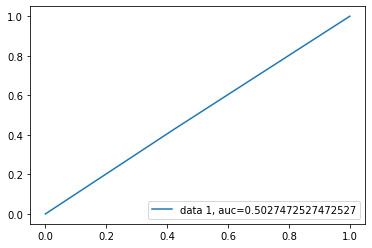

In [232]:
y_pred_proba = gnb.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Multinomial Naive Bayes : Using the 'df' dataset

In [188]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)
predicted_categories = model.predict(X_test)

In [207]:
X=df['Features']
y=df['Birads']

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [191]:
print("The accuracy is {}".format(accuracy_score(y_test, predicted_categories)))

The accuracy is 0.9696969696969697


In [193]:
print(classification_report(y_test, predicted_categories))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       0.00      0.00      0.00         1

    accuracy                           0.97        33
   macro avg       0.48      0.50      0.49        33
weighted avg       0.94      0.97      0.95        33



AUC= 0.5


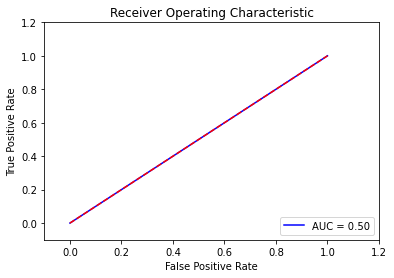

In [201]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicted_categories)
roc_auc = auc(false_positive_rate, true_positive_rate)
print ('AUC=',roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Processing the data for KNN , SVM

In [269]:
X=df['Features']
X = X.apply(lambda x: " ".join(x.lower() for x in x.split()))
X = X.str.replace('[^\w\s]','')
vc=CountVectorizer()
X_vc=vc.fit_transform(X)
X = pd.DataFrame(X_vc.toarray(), columns=vc.get_feature_names())

from sklearn.model_selection import StratifiedKFold
loo=StratifiedKFold(n_splits=10)
TRI=list()
TSI=list()
for train_index,test_index in LOO.split(X,y):
    TSI.append(test_index)
    TRI.append(train_index)
    
    
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
#stop_words = get_stop_words('en')
def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

#X = X.apply(lambda x: remove_stopWords(x))

## K-Nearest Neighbor 

In [271]:
pred=list()
acc=list()

def predict_knn(X_train,y_train,X_test,K=7):
    c_0=0
    c_1=0
    x=X_test
    dist=list()
    for i in X_train.values:
        dist.append(np.linalg.norm(i-x))
    y_train=pd.DataFrame(y_train)
    y_train['Distance']=dist
    dist=np.array(dist)
    np.sort(dist)
    k_smallest=dist[:K]
    k_array=list()
    for i in y_train.values:
        if i[1] in k_smallest:
            k_array.append(i[0])
    for i in k_array:
        if i==0.0:
            c_0+=1
        else:
            c_1+=1
    if c_0>c_1:
        y_predicted=0
    else:
        y_predicted=1
    return y_predicted

for train_index,test_index in zip(TRI,TSI):
    X_train,y_train=X.iloc[train_index],y.iloc[train_index]
    X_test,y_test=X.iloc[test_index],y.iloc[test_index]
    predictions=list()
    ori=list()
    for i,j in zip(X_test.values,y_test.values):
        prediction=predict_knn(X_train,y_train,i,5)
        predictions.append(prediction)
        ori.append(j)
    pred.append(predictions)
    acc.append(accuracy_score(ori,predictions))

In [273]:
TP,FP,TN,FN=0,0,0,0
TPR,FPR,TNR,FNR=0,0,0,0
for i,j in zip(Predictions_list[8],y.iloc[Test_indices[8]]):
    if i==0 and j==0:
        TP+=1
    elif i==0 and j==1:
        FN+=1
    elif i==1 and j==1:
        TN+=1
    else:
        FP+=1
TPR,FPR,TNR,FNR=TP/(TP+FP),FP/(TP+FP),TN/(FN+TN),FN/(FN+TN)

In [274]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / ( TP + FN )
precision = TP / ( TP + FP )
f1 = (2 * recall * precision) / (recall + precision)

In [275]:
print ("------------------------------------------------------------------------------------------")
print ("KNN")
print ("True positives: " + str(TP))
print ("True negatives: " + str(TN))
print ("False positives: " + str(FP))
print ("False negatives: " + str(FN))
print ("Accuracy: " + str(accuracy))
print ("Recall: " + str(recall))
print ("Precision: " + str(precision))
print ("F1 Score: " + str(f1))

------------------------------------------------------------------------------------------
KNN
True positives: 8
True negatives: 0
False positives: 0
False negatives: 2
Accuracy: 0.8
Recall: 0.8
Precision: 1.0
F1 Score: 0.888888888888889


In [252]:
Ones=[1 for i in range(y.iloc[TSI[1]].shape[0])]
Ones=pd.DataFrame(Ones)
FP,TP=list(),list()
FPR,TPR=0.0,0.0
P=[j for j in y.iloc[TSI[1]] if j==1]
N=[j for j in y.iloc[TSI[1]] if j==0]
for k,j in zip(y.iloc[TSI[i]].values,Ones.values):
    if k==j:
        TPR+=1/len(P)
        TP.append(TPR)
        FP.append(FPR)
    else:
        FPR+=1/len(N)
        FP.append(FPR)
        TP.append(TPR)

Text(0.5, 1.0, 'False Positive Rate Vs True Positive Rate')

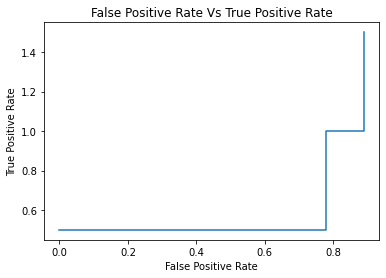

In [217]:
plt.plot(FP,TP)

plt.title('False Positive Rate Vs True Positive Rate')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')                                                      

## Support Vector Machine

In [218]:
from sklearn.svm import SVC,LinearSVC
pred2=list()
acc2=list()
svm=list()

In [219]:
for train_index,test_index in zip(TRI,TSI):
    svc=SVC(probability=True)
    X_train,y_train=X.iloc[train_index],y.iloc[train_index]
    X_test,y_test=X.iloc[test_index],y.iloc[test_index]
    svc.fit(X_train,y_train)
    svm.append(svc)
    predictions=svc.predict(X_test)
    pred2.append(predictions)
    acc2.append(accuracy_score(y_test,predictions))

In [259]:
linear_svc = LinearSVC()
clf = linear_svc.fit(X_train,y_train)
calibrated_svc = CalibratedClassifierCV(base_estimator=linear_svc,cv="prefit")
#calibrated_svc.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(), cv='prefit')

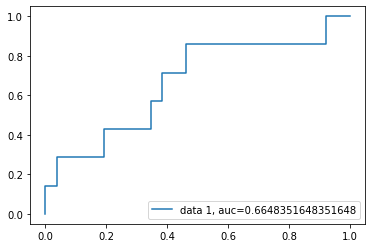

In [260]:
y_pred_proba = calibrated_svc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [265]:
np.mean(Accuracy_list)

0.8036363636363637

In [267]:
print(confusion_matrix(y_test,calibrated_svc.predict(X_test)))

[[24  2]
 [ 5  2]]


In [268]:
print(classification_report(y_test, calibrated_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87        26
           1       0.50      0.29      0.36         7

    accuracy                           0.79        33
   macro avg       0.66      0.60      0.62        33
weighted avg       0.76      0.79      0.76        33



## Inference:

In [276]:
print("From the above 3(binomial classification) and 3(multi-way classification) we have the following results \n")
from tabulate import tabulate 
# assign data
mydata = [["Perceptron", "0.77","0.36"], 
          ["Logistic Regression", "0.85","0.85"], 
          ["Naive Bayes", "0.93","0.95"], 
          ["Multinomial Naive Bayes", "0.97","0.48"],
          ["KNN", "0.79","0.99"],
          ["SVM", "0.80","0.83"]       
         
         ]
  
# create header
head = ["Algorithm", "Accuracy","Precision"]
  
# display table
print(tabulate(mydata, headers=head))

From the above 3(binomial classification) and 3(multi-way classification) we have the following results 

Algorithm                  Accuracy    Precision
-----------------------  ----------  -----------
Perceptron                     0.77         0.36
Logistic Regression            0.85         0.85
Naive Bayes                    0.93         0.95
Multinomial Naive Bayes        0.97         0.48
KNN                            0.79         0.99
SVM                            0.8          0.83


### From the above data and analysis, it can be concluded that Multnomial Naive Bayes (for multi class classification) deploys higher accuracy and comparatively low-precision and Support Vector Machine can be the best model (binary classification) since it has higher Accuracy and very good TPR from the ROC plot.